Forecast the Airlines Passengers data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [138]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.formula.api as smf 
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

In [91]:
airlines_data=pd.read_excel('Airlines+Data.xlsx')
airlines_data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


### Initial Investigation

In [92]:
airlines_data.shape 

(96, 2)

In [93]:
airlines_data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [94]:
airlines_data.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [95]:
airlines_data.set_index('Month',inplace=True)
airlines_data.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


### Data Visualization

<AxesSubplot:xlabel='Month'>

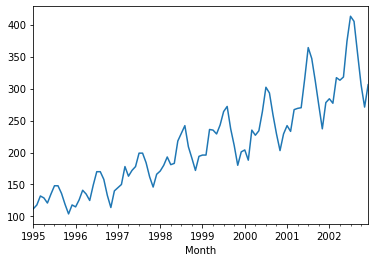

In [96]:
#Line plot for the passengers of Airlines dataset
airlines_data['Passengers'].plot()

From the line plot,we can say that it is upward trend with multiplicative seasonality.

(array([13., 14., 19.,  9., 14., 12.,  9.,  1.,  3.,  2.]),
 array([104. , 134.9, 165.8, 196.7, 227.6, 258.5, 289.4, 320.3, 351.2,
        382.1, 413. ]),
 <BarContainer object of 10 artists>)

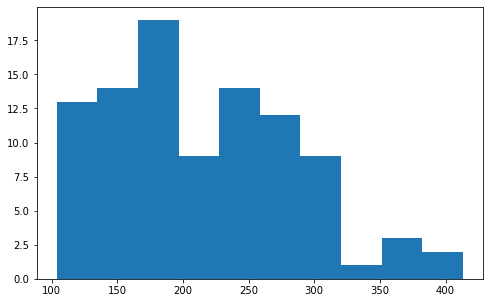

In [97]:
#Histogram
plt.figure(figsize=[8,5])
plt.hist(airlines_data.Passengers)

<AxesSubplot:xlabel='Passengers', ylabel='Density'>

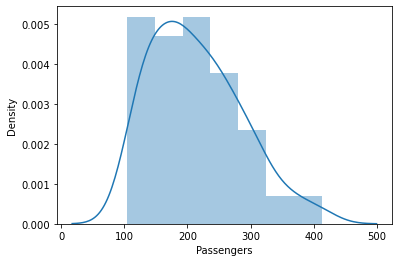

In [98]:
#Density Plot
sns.distplot(airlines_data.Passengers)

From the density plot we can say that passenger data is somewhat normally distributed

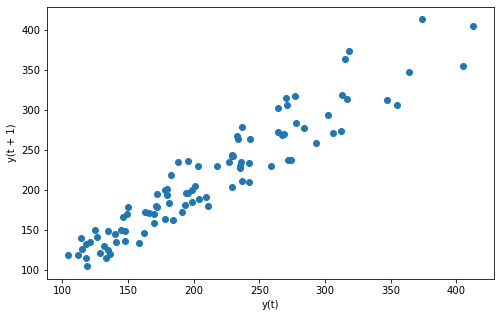

In [99]:
#Lag Plot
plt.figure(figsize=(8,5))
lag_plot(airlines_data['Passengers'])
plt.show()

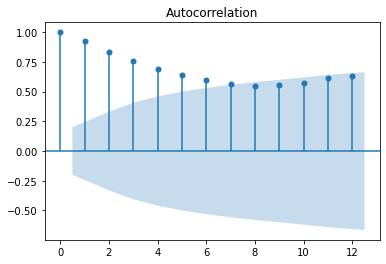

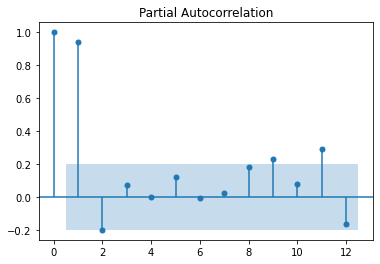

In [100]:
tsa_plots.plot_acf(airlines_data.Passengers,lags=12)
tsa_plots.plot_pacf(airlines_data.Passengers,lags=12)
plt.show()

### Data Driven Forecasting Methods

Splitting the data

In [101]:
Train = airlines_data.head(84)
Test = airlines_data.tail(12)

### Moving Average Method

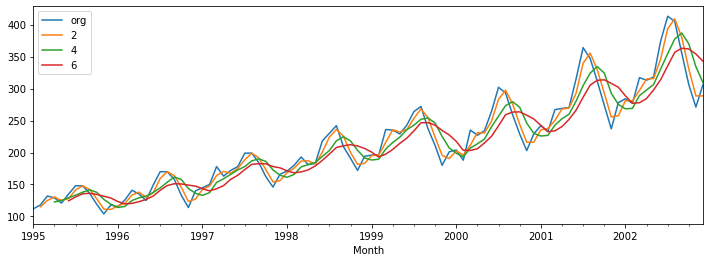

In [102]:
plt.figure(figsize=(12,4))
airlines_data.Passengers.plot(label="org")
for i in range(2,8,2):
    airlines_data["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

With windows=2,we are getting less deviation of the forecasting values with original values

### Time series decomposition plot

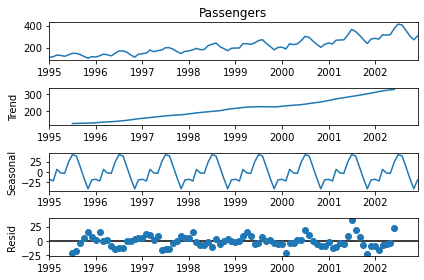

In [103]:
decompose_ts_add = seasonal_decompose(airlines_data.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

### Evaluation Metric RMSE

In [104]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

### Simple Exponential Method

In [105]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses_model=RMSE(pred_ses,Test.Passengers) 
rmse_ses_model

64.84476396990442

### Holt Method

In [106]:
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw_model=RMSE(pred_hw,Test.Passengers) 
rmse_hw_model

95.76674452675374

### Holts winter exponential smoothing with additive seasonality and additive trend

In [107]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add_model=RMSE(pred_hwe_add_add,Test.Passengers) 
rmse_hwe_add_add_model

28.80730725721676

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [108]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_model_mul_add_model=RMSE(pred_hwe_mul_add,Test.Passengers)
rmse_hwe_model_mul_add_model

12.919179883239396

### Model Based Forecasting Methods

In [110]:
airlines_data1=airlines_data.copy()
airlines_data1.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [111]:
#Data preprocessing for models
airlines_data1["t"] = np.arange(1,97)
airlines_data1["t_squared"] = airlines_data1["t"]*airlines_data1["t"]
airlines_data1["log_psngr"] = np.log(airlines_data1["Passengers"])
airlines_data1.head()

,Passengers,t,t_squared,log_psngr
Month,,,,
1995-01-01,112,1,1,4.718499
1995-02-01,118,2,4,4.770685
1995-03-01,132,3,9,4.882802
1995-04-01,129,4,16,4.859812
1995-05-01,121,5,25,4.795791


Splitting the data

In [112]:
Train = airlines_data1.head(84)
Test = airlines_data1.tail(12)

### Linear Model

In [113]:
linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

53.19923653480267

### Exponential Model

In [114]:
Exp = smf.ols('log_psngr~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.05736110315608

### Quadratic Model

In [115]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

48.05188897933096

### Arima Models

Arima Models can be applied only for stationary data which does not have trend and seasonal component and
mean and variance should be approximately same.

Checking stationarity

In [116]:
airlines_data2=airlines_data.copy()
airlines_data2

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [117]:
#Determing rolling statistics
rolmean = airlines_data2.rolling(window=12).mean()
rolstd = airlines_data2.rolling(window=12).std()

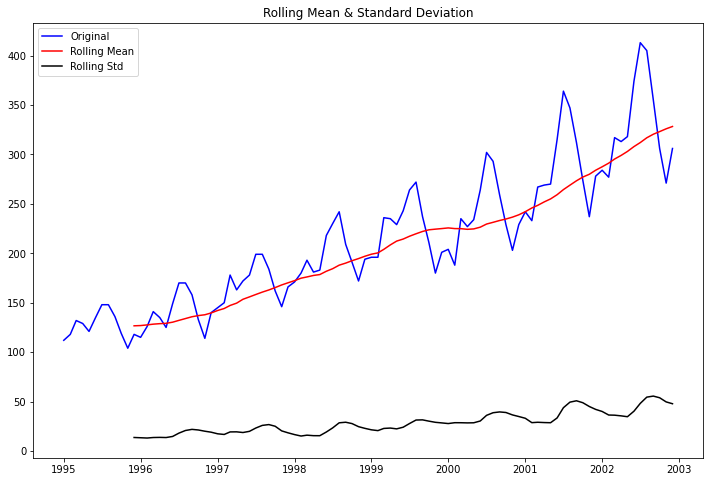

In [120]:
#Plot rolling statistics:
plt.rcParams['figure.figsize'] = (12,8) 
orig = plt.plot(airlines_data2, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

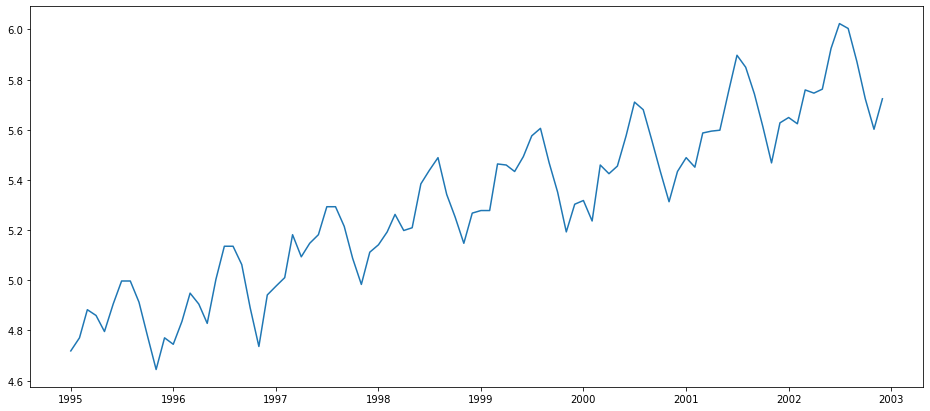

In [121]:
#log transformation
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log = np.log(airlines_data2)#to transform to stationary from non-stationary
plt.plot(ts_log)

Even after doing log transformation,it is not becoming stationary.

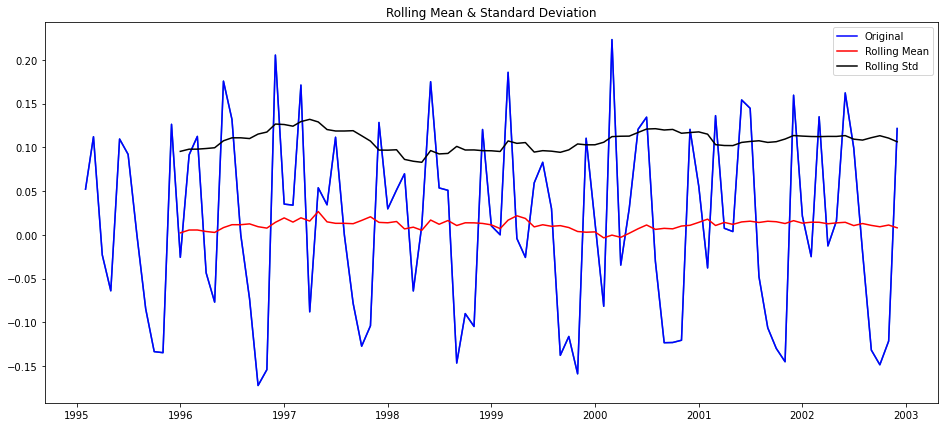

In [122]:
#differencing
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift() #Shifting the time series by 1 and subtract from the original TS.
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()


#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

After differencing,there is no pattern in the mean.No upward trend.
So by the definition of stationarity,mean and SD would be almost similar.There wont be much differences.

In [124]:
#separate out a validation dataset
split_point = len(airlines_data2) - 10
dataset, validation = airlines_data2[0:split_point],airlines_data2[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 86, Validation 10


### Persistence/Base Model

In [128]:
#evaluate a persistence model
#load data
train = read_csv('dataset.csv',header=None,index_col=0,parse_dates=True,squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train,test = X[0:train_size],X[train_size:]


In [129]:
print(train.shape)
print(test.shape)

(43,)
(43,)


In [130]:
#walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
#observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
#report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

In [147]:
rmse_Persistence_model=25.698

### Arima Hyperparameters

In [133]:
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
#make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
#calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [134]:
#evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [136]:
#load dataset
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=78.563
ARIMA(0, 0, 1) RMSE=44.789
ARIMA(0, 1, 0) RMSE=25.903
ARIMA(0, 1, 1) RMSE=25.355
ARIMA(0, 1, 2) RMSE=27.772
ARIMA(0, 1, 3) RMSE=23.806
ARIMA(0, 1, 4) RMSE=22.640
ARIMA(0, 2, 0) RMSE=32.474
ARIMA(0, 2, 1) RMSE=26.640
ARIMA(0, 2, 2) RMSE=25.942
ARIMA(0, 2, 3) RMSE=27.914
ARIMA(0, 2, 4) RMSE=25.149
ARIMA(1, 0, 0) RMSE=26.036
ARIMA(1, 0, 1) RMSE=25.282
ARIMA(1, 0, 2) RMSE=488.705
ARIMA(1, 1, 0) RMSE=25.679
ARIMA(1, 2, 0) RMSE=31.603
ARIMA(2, 0, 0) RMSE=25.620
ARIMA(2, 1, 0) RMSE=25.467
ARIMA(2, 2, 0) RMSE=30.414
ARIMA(3, 0, 0) RMSE=25.510
ARIMA(3, 0, 1) RMSE=24.850
ARIMA(3, 1, 0) RMSE=25.648
ARIMA(3, 2, 0) RMSE=30.597
ARIMA(4, 0, 0) RMSE=25.764
ARIMA(4, 1, 0) RMSE=25.344
ARIMA(4, 2, 0) RMSE=29.205
ARIMA(4, 2, 1) RMSE=26.016
Best ARIMA(0, 1, 4) RMSE=22.640


In [ ]:
#Best ARIMA hyperparameters=(0,1,4) with RMSE 22.640

In [144]:
rmse_ARIMA_model = 22.640

### Build Model based on the optimized values

In [137]:
#load data
train = pd.read_csv('dataset.csv',header=0,index_col=0, parse_dates=True)
#prepare data
X = train.values
X = X.astype('float32')

### AR Model

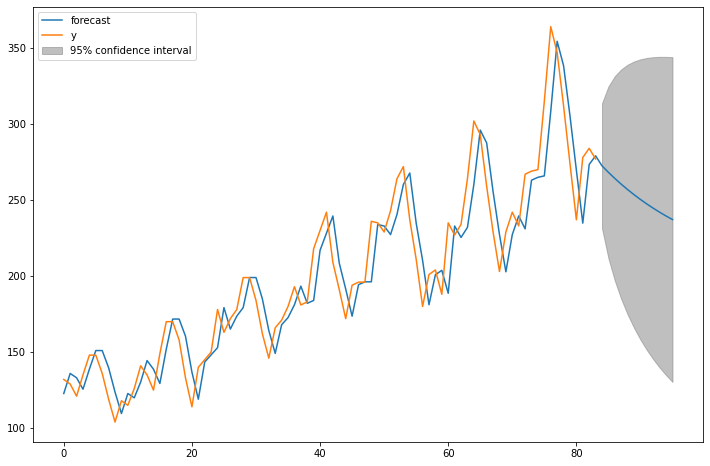

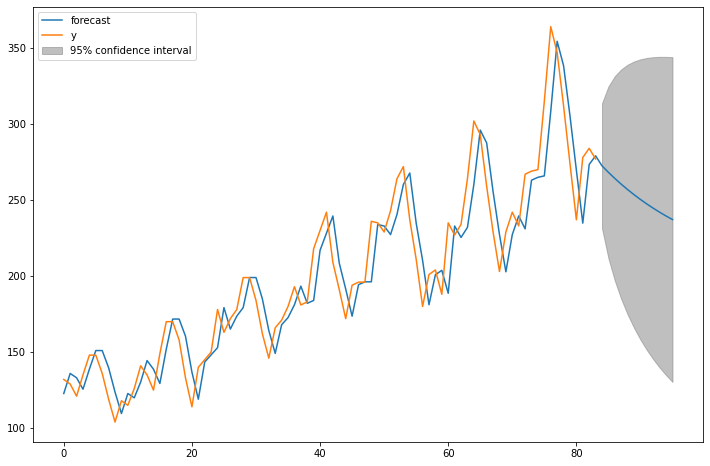

In [139]:
#fit model
model = ARMA(X,order=(1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,96)

### MA Model

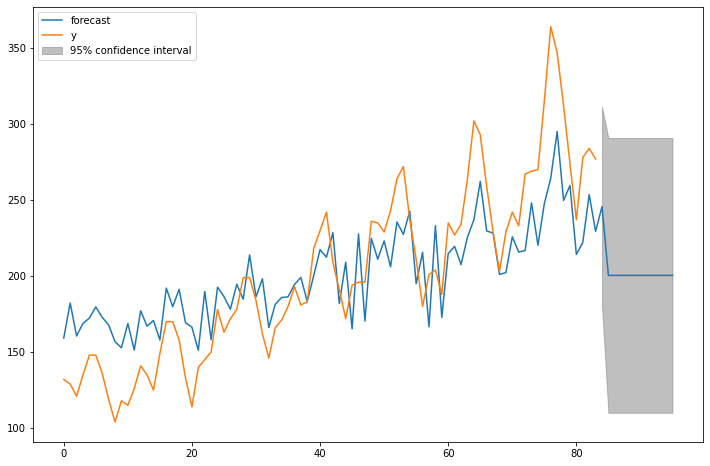

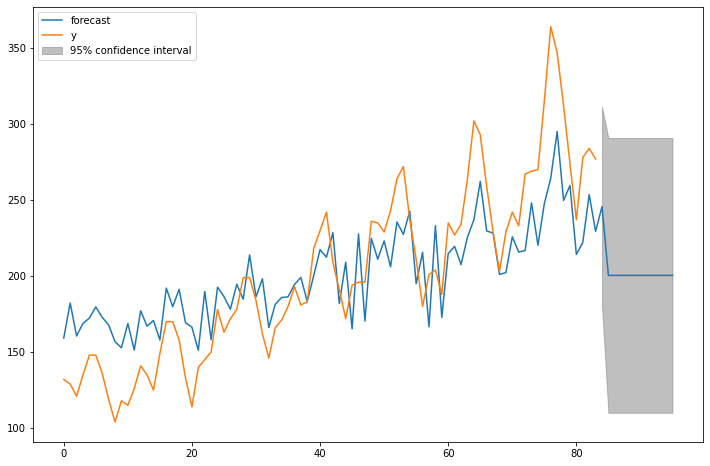

In [140]:
#fit model
model = ARMA(X,order=(0,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,96)

### ARMA Model

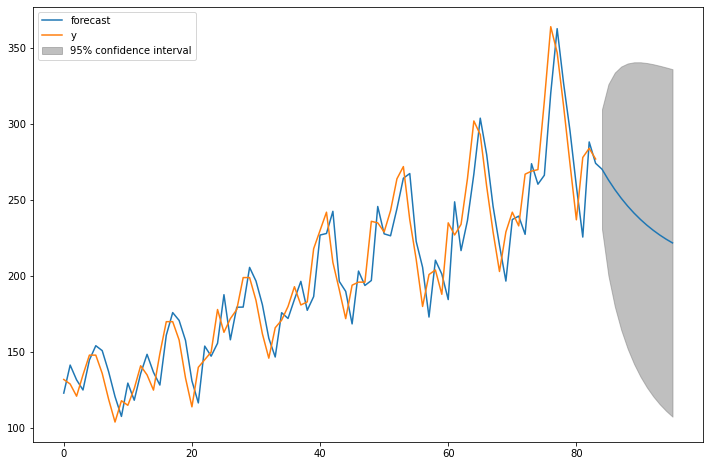

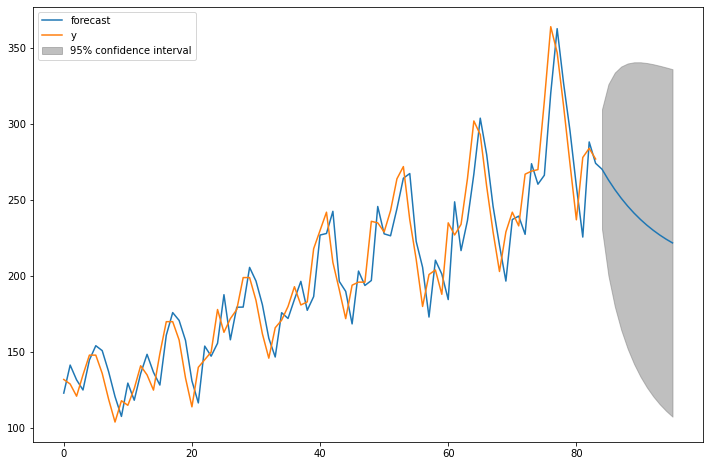

In [141]:
#fit model
model = ARMA(X,order=(1,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,96)

### ARIMA Model

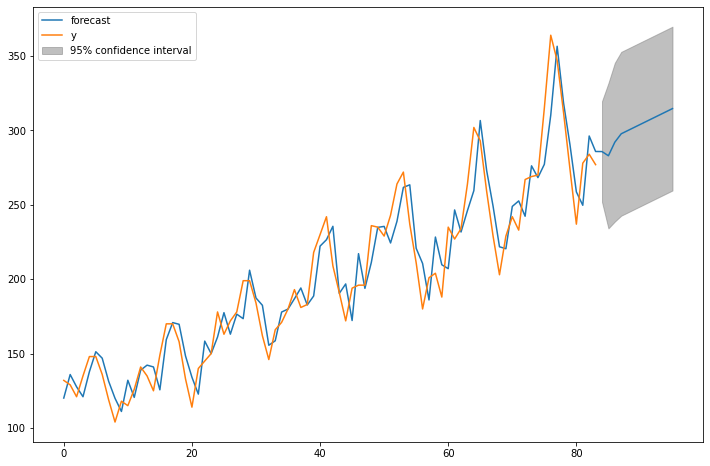

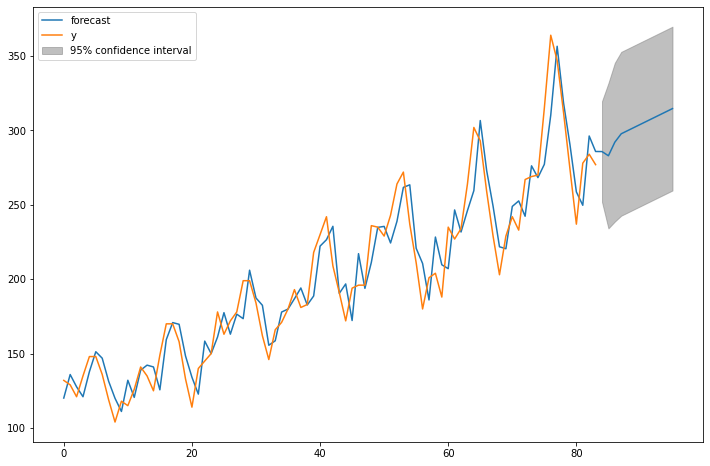

In [142]:
# fit model
model = ARIMA(X,order=(0,1,4))
model_fit = model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,96)

In [143]:
forecast

array([285.79387943, 282.98501436, 292.08845741, 297.7547027 ,
       299.8703904 , 301.9860781 , 304.10176581, 306.21745351,
       308.33314121, 310.44882891, 312.56451662, 314.68020432])

In [148]:
list = [['Simple Exponential Method',rmse_ses_model], ['Holt method',rmse_hw_model],
       ['HW exp smoothing add',rmse_hwe_add_add_model],['HW exp smoothing mult',rmse_hwe_model_mul_add_model],
       ['Linear Model',rmse_linear],['Exp model',rmse_Exp],['Quad model',rmse_Quad],
       ['Persistence/ Base model', rmse_Persistence_model],['ARIMA Model',rmse_ARIMA_model]]


In [149]:
df=pd.DataFrame(list,columns =['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Simple Exponential Method,64.844764
1,Holt method,95.766745
2,HW exp smoothing add,28.807307
3,HW exp smoothing mult,12.919180
4,Linear Model,53.199237
5,Exp model,46.057361
6,Quad model,48.051889
7,Persistence/ Base model,25.698000
8,ARIMA Model,22.640000


We can see that we are getting lowest RMSE value for  Holts winter exponential smoothing with multiplicative seasonality and additive trend

### Building final Model with least RMSE value

In [155]:
final_model = ExponentialSmoothing(airlines_data["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_final= final_model.predict(start = airlines_data.index[0],end = airlines_data.index[-1])
rmse_final_model=RMSE(pred_final,airlines_data["Passengers"])
rmse_final_model

6.787458388740889

In [159]:
pred_df = pd.DataFrame({'Actual' : airlines_data.Passengers, 'Predicted' :pred_final})
pred_df

,Actual,Predicted
1995-01-01,112,113.177956
1995-02-01,118,111.887419
1995-03-01,132,135.732962
1995-04-01,129,130.699044
1995-05-01,121,130.785769
...,...,...
2002-08-01,405,406.594341
2002-09-01,355,358.686297
2002-10-01,306,311.277494
2002-11-01,271,268.937280


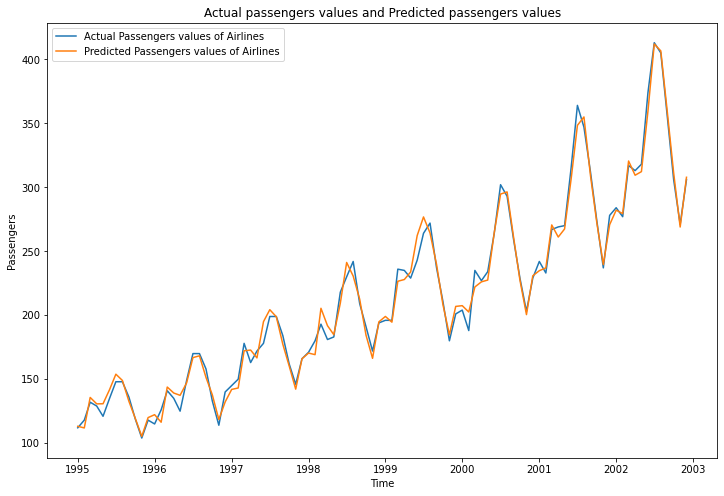

In [162]:
#Plot of Actual Passengers values and Predicted Passengers values
plt.plot(airlines_data.Passengers,label='Actual Passengers values of Airlines')
plt.plot(pred_final,label='Predicted Passengers values of Airlines')

plt.title('Actual passengers values and Predicted passengers values')
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.rcParams['figure.figsize'] = (12,8) 
plt.show()